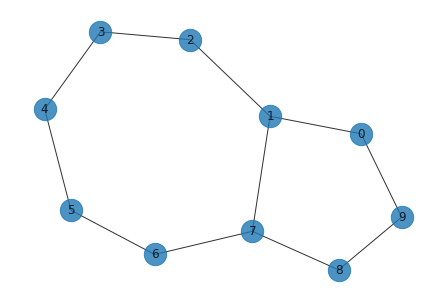

In [1]:
import warnings
warnings.simplefilter(action='ignore',)

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

from time import time
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0,1,2,3,4,5,6,7,8,9])
G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(4,5),(1, 7),(5,6),(6,7),(7,8),(8,9),(9,0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

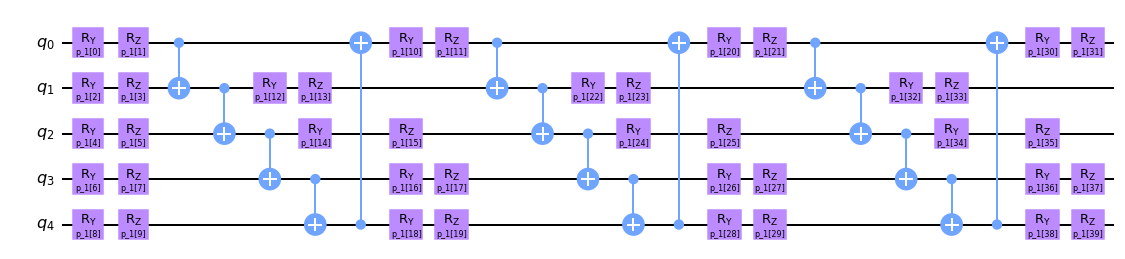

In [2]:
repeat = 4

qc_u1 = QuantumCircuit(5)
pv_u1 = ParameterVector('p_1', 10*repeat)

t = 0
for i in range(repeat):   
    qc_u1.ry(pv_u1[t], 0)
    qc_u1.rz(pv_u1[t+1],0)
    qc_u1.ry(pv_u1[t+2], 1)
    qc_u1.rz(pv_u1[t+3], 1)
    qc_u1.ry(pv_u1[t+4], 2)
    qc_u1.rz(pv_u1[t+5], 2)
    qc_u1.ry(pv_u1[t+6], 3)
    qc_u1.rz(pv_u1[t+7], 3)
    qc_u1.ry(pv_u1[t+8], 4)
    qc_u1.rz(pv_u1[t+9], 4)
    if i < repeat-1: 
        qc_u1.cnot(0,1)
        qc_u1.cnot(1,2)
        qc_u1.cnot(2,3)
        qc_u1.cnot(3,4)
        qc_u1.cnot(4,0)
    t += 10

qc_u1.draw(output="mpl")

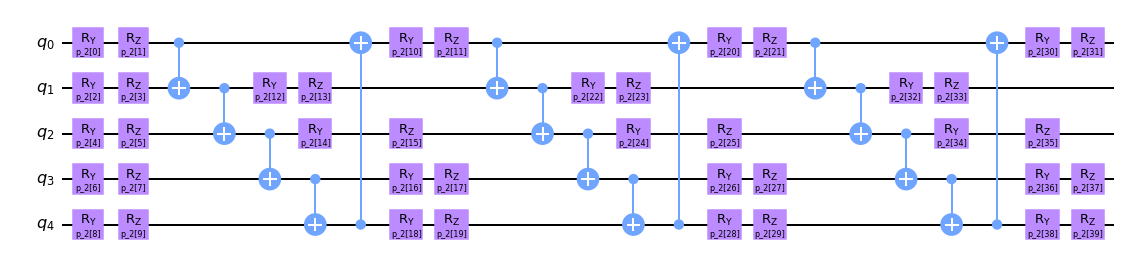

In [3]:
repeat = 4

qc_u2 = QuantumCircuit(5)
pv_u2 = ParameterVector('p_2', 10*repeat)

t = 0
for i in range(repeat):   
    qc_u2.ry(pv_u2[t], 0)
    qc_u2.rz(pv_u2[t+1],0)
    qc_u2.ry(pv_u2[t+2], 1)
    qc_u2.rz(pv_u2[t+3], 1)
    qc_u2.ry(pv_u2[t+4], 2)
    qc_u2.rz(pv_u2[t+5], 2)
    qc_u2.ry(pv_u2[t+6], 3)
    qc_u2.rz(pv_u2[t+7], 3)
    qc_u2.ry(pv_u2[t+8], 4)
    qc_u2.rz(pv_u2[t+9], 4)
    if i < repeat-1: 
        qc_u2.cnot(0,1)
        qc_u2.cnot(1,2)
        qc_u2.cnot(2,3)
        qc_u2.cnot(3,4)
        qc_u2.cnot(4,0)
    t += 10

qc_u2.draw(output="mpl")

In [4]:
def create_circ(G, theta):
    
    qc = QuantumCircuit(10)
    
    r = 4
    pv = ParameterVector('p',2*10*r)
    
    t = 0
    for i in range(r):   
        qc.ry(theta[t], 0)
        qc.rz(theta[t+1],0)
        qc.ry(theta[t+2], 1)
        qc.rz(theta[t+3], 1)
        qc.ry(theta[t+4], 2)
        qc.rz(theta[t+5], 2)
        qc.ry(theta[t+6], 3)
        qc.rz(theta[t+7], 3)
        qc.ry(theta[t+8], 4)
        qc.rz(theta[t+9], 4)
        if i < r-1: 
            qc.cnot(0,1)
            qc.cnot(1,2)
            qc.cnot(2,3)
            qc.cnot(3,4)
            qc.cnot(4,0)
        t += 10

    t = int(len(theta)/2)
    for i in range(r):   
        qc.ry(theta[t], 5)
        qc.rz(theta[t+1],5)
        qc.ry(theta[t+2], 6)
        qc.rz(theta[t+3], 6)
        qc.ry(theta[t+4], 7)
        qc.rz(theta[t+5], 7)
        qc.ry(theta[t+6], 8)
        qc.rz(theta[t+7], 8)
        qc.ry(theta[t+8], 9)
        qc.rz(theta[t+9], 9)
        if i < r-1: 
            qc.cnot(5,6)
            qc.cnot(6,7)
            qc.cnot(7,8)
            qc.cnot(8,9)
            qc.cnot(9,5)
        t += 10
    
    qc.measure_all()
    return qc

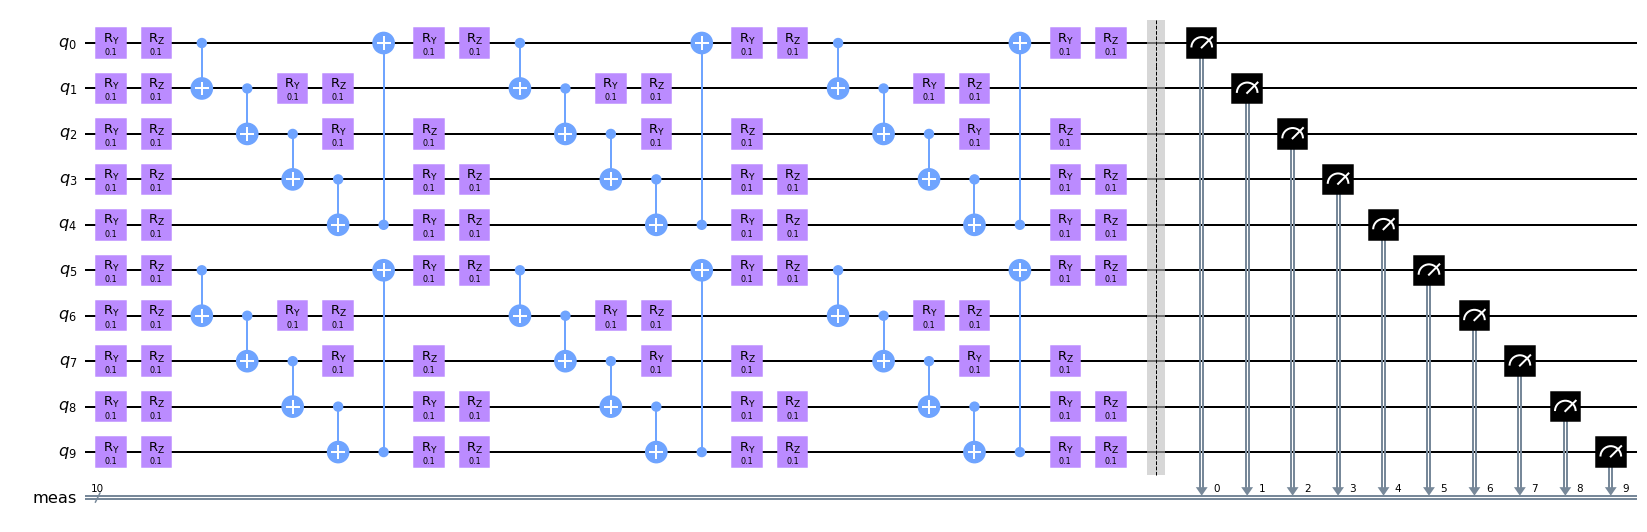

In [5]:
para = []
repeat = 4
for i in range(repeat*2*10): para.append(0.1)

qc_test = create_circ(G, para)

qc_test.draw(output="mpl", fold=-1)

In [6]:
def maxcut_obj(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

# maxcut_obj([0,1,1,0], G)

def compute_expectation(counts, G):
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def get_expectation(G, p, shots=1024):
     
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=1024).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [7]:
from scipy.optimize import minimize

expectation = get_expectation(G, p=50)
res = minimize(expectation, 
              para, 
              method='COBYLA')
res

     fun: -8.859375
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 1000
  status: 2
 success: False
       x: array([ 1.68142223e+00, -2.45837844e-02,  1.50522431e+00, -5.78059630e-02,
        1.93744406e-01,  5.74080555e-01,  1.67256868e+00, -1.02824387e-01,
        5.21759092e-01, -7.18313710e-01,  1.43493187e+00,  4.65756348e-01,
        1.28409687e+00, -1.04129102e+00,  1.40751792e+00, -2.49805751e-01,
       -4.32610593e-01,  1.79702688e-02, -3.99563674e-01, -1.85774592e-01,
        6.75420244e-02, -5.27061926e-01,  3.88808272e-01,  5.66230487e-01,
       -1.83905615e-01,  1.40472382e+00,  1.50891010e+00,  1.64124976e+00,
        6.22357142e-02,  6.78988570e-01,  3.31116238e-02, -3.33317028e-02,
       -2.57756804e-01, -1.29608971e-01, -1.99008551e-02,  2.62531001e-02,
       -3.37414686e-02, -2.97407077e-01,  4.29646486e-01, -7.23807741e-01,
        2.24576789e-01,  1.32907472e+00,  2.03959785e+00,  3.00201560e-01,
        1.33617155

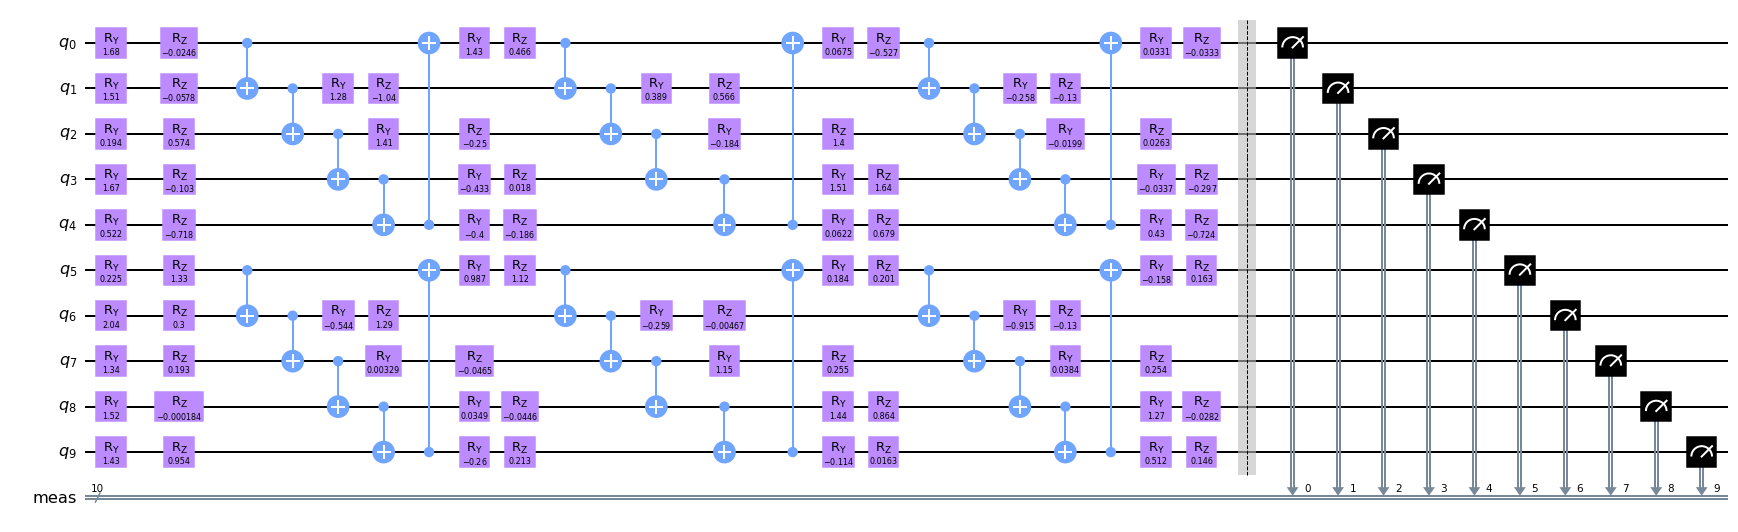

In [8]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 1024

qc_res = create_circ(G, res.x)

qc_res.draw(output="mpl",fold=-1)

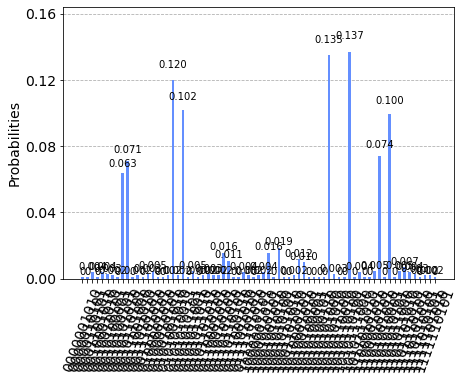

In [9]:
result = backend.run(qc_res, seed_simulator=10).result()
counts = result.get_counts()
plot_histogram(counts)

In [10]:
sort = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
print("Best 4 solutions:")
es = 0
for i in sort:
    print(i)
    es+=1
    if es == 4: break

Best 4 solutions:
1010110101
1010101010
0101001010
0101010101


In [11]:
ans = "1010101010"

import cvxpy as cvx
import networkx as nx

def sdp_solver(G):

    n = len(G)
    adj_mat = nx.adjacency_matrix(G).toarray()
    Y = cvx.Variable((n, n), PSD=True)
    cut_size = 0.25 * cvx.sum(cvx.multiply(adj_mat, 1 - Y))
    problem = cvx.Problem(cvx.Maximize(cut_size), [cvx.diag(Y) == 1])
    opt_val = problem.solve(cvx.SCS)

    return opt_val

ubound_sdp = sdp_solver(G)
print("SDP upper bound: " + str(ubound_sdp))

cut_dc_qaoa1 = ["solid" if ans[u] == ans[v] else "dashed" for (u, v) in list(G.edges)]
value_dc_qaoa = cut_dc_qaoa1.count("dashed")
print("binary string: " + str(ans) + ", max cut = " + str(float(value_dc_qaoa))) 

SDP upper bound: 10.30128894705788
binary string: 1010101010, max cut = 10.0


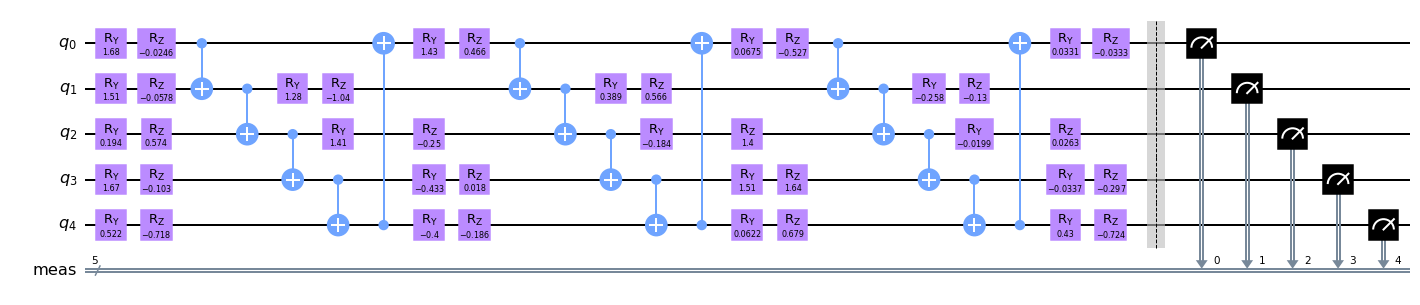

In [12]:
repeat = 4

qc_u1 = QuantumCircuit(5)
pv_u1 = ParameterVector('p_1', 10*repeat)

t = 0
for i in range(repeat):   
    qc_u1.ry(res.x[t], 0)
    qc_u1.rz(res.x[t+1],0)
    qc_u1.ry(res.x[t+2], 1)
    qc_u1.rz(res.x[t+3], 1)
    qc_u1.ry(res.x[t+4], 2)
    qc_u1.rz(res.x[t+5], 2)
    qc_u1.ry(res.x[t+6], 3)
    qc_u1.rz(res.x[t+7], 3)
    qc_u1.ry(res.x[t+8], 4)
    qc_u1.rz(res.x[t+9], 4)
    if i < repeat-1: 
        qc_u1.cnot(0,1)
        qc_u1.cnot(1,2)
        qc_u1.cnot(2,3)
        qc_u1.cnot(3,4)
        qc_u1.cnot(4,0)
    t += 10

qc_u1.measure_all()
qc_u1.draw(output="mpl", fold=-1)

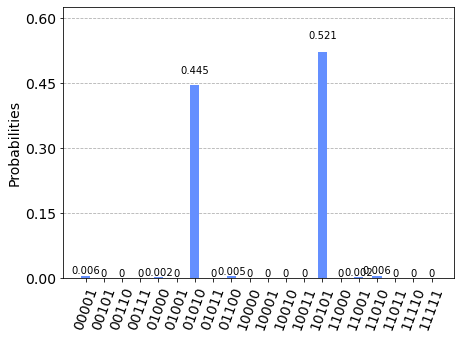

In [13]:
result = backend.run(qc_u1, seed_simulator=10).result()
counts = result.get_counts()
plot_histogram(counts)

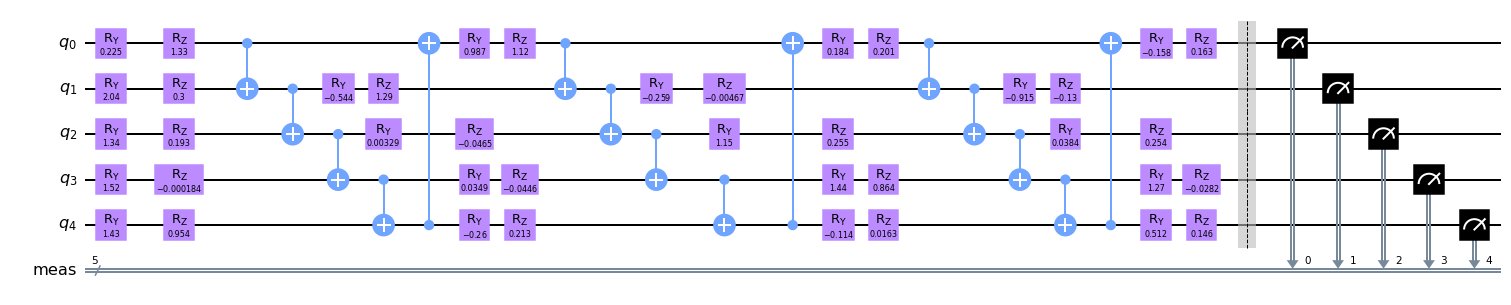

In [14]:
repeat = 4
qc_u2 = QuantumCircuit(5)
pv_u2 = ParameterVector('p_2', 10*repeat)

t = int(len(res.x)/2)

for i in range(repeat):   
    qc_u2.ry(res.x[t], 0)
    qc_u2.rz(res.x[t+1],0)
    qc_u2.ry(res.x[t+2], 1)
    qc_u2.rz(res.x[t+3], 1)
    qc_u2.ry(res.x[t+4], 2)
    qc_u2.rz(res.x[t+5], 2)
    qc_u2.ry(res.x[t+6], 3)
    qc_u2.rz(res.x[t+7], 3)
    qc_u2.ry(res.x[t+8], 4)
    qc_u2.rz(res.x[t+9], 4)
    if i < repeat-1: 
        qc_u2.cnot(0,1)
        qc_u2.cnot(1,2)
        qc_u2.cnot(2,3)
        qc_u2.cnot(3,4)
        qc_u2.cnot(4,0)
    t += 10

qc_u2.measure_all()
qc_u2.draw(output="mpl",fold=-1)

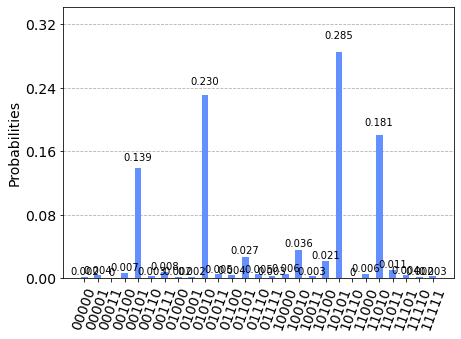

In [15]:
result = backend.run(qc_u2, seed_simulator=10).result()
counts = result.get_counts()
plot_histogram(counts)